### Libraries Required:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM, GRU, Dense, Attention
from keras.callbacks import EarlyStopping
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.layers import Attention

### Loading Dataset:

In [ ]:
data = pd.read_csv('Dataset_Exercise_2.csv')

### Preprocessing Data

In [ ]:
# Create the new feature: Occupancy Rate
data['OccupancyRate'] = data['Occupancy'] / data['Capacity']

# Convert 'LastUpdated' column to datetime
data['LastUpdated'] = pd.to_datetime(data['LastUpdated'])

In [ ]:
data.drop(['Capacity', 'Occupancy'], axis=1, inplace=True)

In [ ]:
data = data[data['SystemCodeNumber'].str.contains('Shopping')]

In [ ]:
data.head()

,SystemCodeNumber,LastUpdated,OccupancyRate
34405,Shopping,2016-10-04 07:59:42,0.319792
34406,Shopping,2016-10-04 08:25:42,0.396354
34407,Shopping,2016-10-04 08:59:42,0.498958
34408,Shopping,2016-10-04 09:32:46,0.583854
34409,Shopping,2016-10-04 09:59:48,0.653125


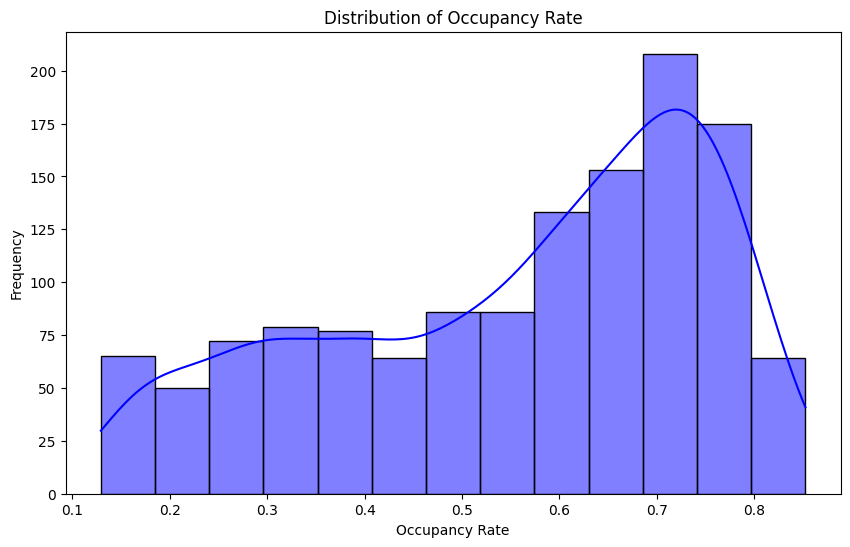

In [ ]:
# Check the distribution of the 'Occupancy Rate' variable
plt.figure(figsize=(10, 6))
sns.histplot(data['OccupancyRate'], kde=True, color='blue')
plt.title('Distribution of Occupancy Rate')
plt.xlabel('Occupancy Rate')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Check the scale of the 'Occupancy Rate' variable
print("Summary statistics of Occupancy Rate:")
print(data['OccupancyRate'].describe())

Summary statistics of Occupancy Rate:
count    1312.000000
mean        0.555697
std         0.194023
min         0.129167
25%         0.402083
50%         0.605208
75%         0.719271
max         0.852604
Name: OccupancyRate, dtype: float64


In [ ]:
# Split data into train and test based on 'LastUpdated' column
train_data = data[data['LastUpdated'] < '2016-12-01']
test_data = data[data['LastUpdated'] >= '2016-12-01']

In [ ]:
# Define features and target variable
X_train = train_data[['OccupancyRate']].values
y_train = train_data['OccupancyRate'].values
X_test = test_data[['OccupancyRate']].values
y_test = test_data['OccupancyRate'].values

# **RNN Experimentation and Attention**

In [ ]:
# Define evaluation metric (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [ ]:
def create_rnn_model(model_type='LSTM', units=50, num_layers=1, use_attention=False):
    model = Sequential()
    if model_type == 'LSTM':
        for i in range(num_layers):
            if use_attention and i == num_layers - 1:
                model.add(LSTM(units, return_sequences=True))
                model.add(Attention())
            elif i == num_layers - 1:
                model.add(LSTM(units, return_sequences=False))
            else:
                model.add(LSTM(units, return_sequences=True))
    elif model_type == 'GRU':
        for i in range(num_layers):
            if use_attention and i == num_layers - 1:
                model.add(GRU(units, return_sequences=True))
                model.add(Attention())
            elif i == num_layers - 1:
                model.add(GRU(units, return_sequences=False))
            else:
                model.add(GRU(units, return_sequences=True))
    else:
        raise ValueError("Invalid model type. Choose 'LSTM' or 'GRU'.")

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])
    return model

In [ ]:
# Define a function to train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    _, rmse = model.evaluate(X_test, y_test, verbose=0)
    return rmse

In [ ]:
# Define hyperparameters configurations to try
rnn_configs = [
    {'model_type': 'LSTM', 'units': 10, 'num_layers': 1},
    {'model_type': 'LSTM', 'units': 10, 'num_layers': 2},
    {'model_type': 'LSTM', 'units': 25, 'num_layers': 1},
    {'model_type': 'LSTM', 'units': 25, 'num_layers': 2},
    {'model_type': 'LSTM', 'units': 50, 'num_layers': 1},
    {'model_type': 'LSTM', 'units': 50, 'num_layers': 2},
    {'model_type': 'LSTM', 'units': 100, 'num_layers': 1},
    {'model_type': 'LSTM', 'units': 100, 'num_layers': 2},
    {'model_type': 'GRU', 'units': 10, 'num_layers': 1},
    {'model_type': 'GRU', 'units': 10, 'num_layers': 2},
    {'model_type': 'GRU', 'units': 25, 'num_layers': 1},
    {'model_type': 'GRU', 'units': 25, 'num_layers': 2},
    {'model_type': 'GRU', 'units': 50, 'num_layers': 1},
    {'model_type': 'GRU', 'units': 50, 'num_layers': 2},
    {'model_type': 'GRU', 'units': 100, 'num_layers': 1},
    {'model_type': 'GRU', 'units': 100, 'num_layers': 2}
]

In [ ]:
# Reshape input data
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Train and evaluate models with different configurations
results = []
for config in rnn_configs:
    print(f"Evaluating {config['model_type']} with {config['num_layers']} layers and {config['units']} units per layer")
    model = create_rnn_model(model_type=config['model_type'], units=config['units'], num_layers=config['num_layers'])
    rmse = train_and_evaluate_model(model, X_train_reshaped, y_train, X_test_reshaped, y_test)
    results.append({'config': config, 'rmse': rmse})

Evaluating LSTM with 1 layers and 10 units per layer
Epoch 1/50
26/26 [==============================] - 4s 28ms/step - loss: 0.3264 - root_mean_squared_error: 0.5651 - val_loss: 0.3664 - val_root_mean_squared_error: 0.6123
Epoch 2/50
26/26 [==============================] - 0s 5ms/step - loss: 0.2430 - root_mean_squared_error: 0.4907 - val_loss: 0.2756 - val_root_mean_squared_error: 0.5311
Epoch 3/50
26/26 [==============================] - 0s 5ms/step - loss: 0.1757 - root_mean_squared_error: 0.4208 - val_loss: 0.2025 - val_root_mean_squared_error: 0.4553
Epoch 4/50
26/26 [==============================] - 0s 5ms/step - loss: 0.1230 - root_mean_squared_error: 0.3469 - val_loss: 0.1440 - val_root_mean_squared_error: 0.3840
Epoch 5/50
26/26 [==============================] - 0s 5ms/step - loss: 0.0836 - root_mean_squared_error: 0.2869 - val_loss: 0.1002 - val_root_mean_squared_error: 0.3205
Epoch 6/50
26/26 [==============================] - 0s 5ms/step - loss: 0.0554 - root_mean_squar

In [ ]:
# Print results
for result in results:
    print(f"Configuration: {result['config']}, RMSE: {result['rmse']}")

Configuration: {'model_type': 'LSTM', 'units': 10, 'num_layers': 1}, RMSE: 0.02563311532139778
Configuration: {'model_type': 'LSTM', 'units': 10, 'num_layers': 2}, RMSE: 0.011667264625430107
Configuration: {'model_type': 'LSTM', 'units': 25, 'num_layers': 1}, RMSE: 0.005357833579182625
Configuration: {'model_type': 'LSTM', 'units': 25, 'num_layers': 2}, RMSE: 0.013116491958498955
Configuration: {'model_type': 'LSTM', 'units': 50, 'num_layers': 1}, RMSE: 0.006344243884086609
Configuration: {'model_type': 'LSTM', 'units': 50, 'num_layers': 2}, RMSE: 0.012631739489734173
Configuration: {'model_type': 'LSTM', 'units': 100, 'num_layers': 1}, RMSE: 0.005519369151443243
Configuration: {'model_type': 'LSTM', 'units': 100, 'num_layers': 2}, RMSE: 0.00891475286334753
Configuration: {'model_type': 'GRU', 'units': 10, 'num_layers': 1}, RMSE: 0.0005876055220142007
Configuration: {'model_type': 'GRU', 'units': 10, 'num_layers': 2}, RMSE: 0.00279177725315094
Configuration: {'model_type': 'GRU', 'unit

In [ ]:
# Identify the best performing model
best_model_config = min(results, key=lambda x: x['rmse'])['config']
print("Best performing model configuration:", best_model_config)

Best performing model configuration: {'model_type': 'GRU', 'units': 10, 'num_layers': 1}


In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

# Reshape input data
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Train the best-performing RNN model
best_rnn_model = create_rnn_model(model_type=best_model_config['model_type'], units=best_model_config['units'], num_layers=best_model_config['num_layers'])
best_rnn_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/50
26/26 [==============================] - 3s 24ms/step - loss: 0.4357 - root_mean_squared_error: 0.6599 - val_loss: 0.4736 - val_root_mean_squared_error: 0.6961
Epoch 2/50
26/26 [==============================] - 0s 5ms/step - loss: 0.2977 - root_mean_squared_error: 0.5360 - val_loss: 0.3308 - val_root_mean_squared_error: 0.5819
Epoch 3/50
26/26 [==============================] - 0s 4ms/step - loss: 0.1973 - root_mean_squared_error: 0.4409 - val_loss: 0.2209 - val_root_mean_squared_error: 0.4756
Epoch 4/50
26/26 [==============================] - 0s 4ms/step - loss: 0.1208 - root_mean_squared_error: 0.3423 - val_loss: 0.1376 - val_root_mean_squared_error: 0.3758
Epoch 5/50
26/26 [==============================] - 0s 5ms/step - loss: 0.0695 - root_mean_squared_error: 0.2618 - val_loss: 0.0821 - val_root_mean_squared_error: 0.2913
Epoch 6/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0419 - root_mean_squared_error: 0.2024 - val_loss: 0.0521 - val_root_mean_s

## To show how the attention mechanism is working

10/10 [==============================] - 0s 2ms/step


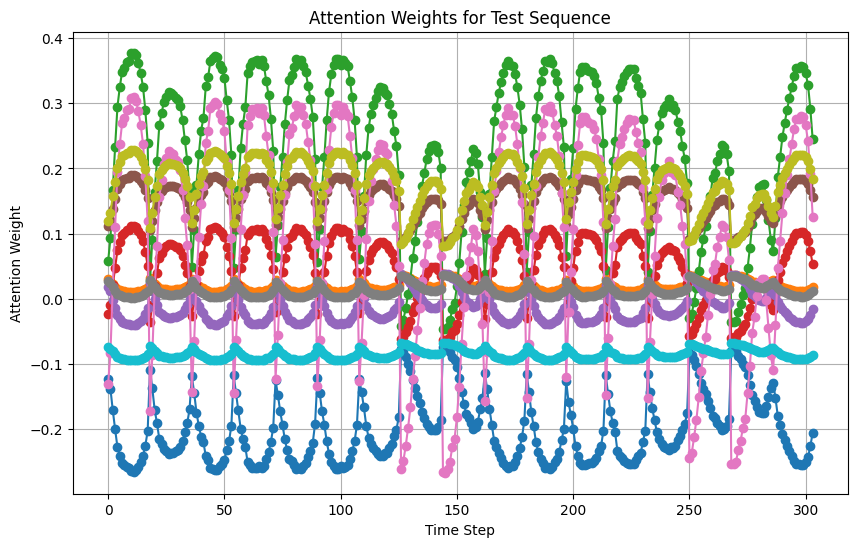

In [ ]:
# Define a new model that outputs attention weights
attention_extractor = Model(inputs=best_rnn_model.input, outputs=best_rnn_model.layers[-2].output)

# Get attention weights for the test set
attention_weights = attention_extractor.predict(X_test_reshaped)

# Plot attention weights
plt.figure(figsize=(10, 6))
plt.plot(range(len(X_test)), attention_weights.squeeze(), marker='o')
plt.xlabel('Time Step')
plt.ylabel('Attention Weight')
plt.title('Attention Weights for Test Sequence')
plt.grid(True)
plt.show()

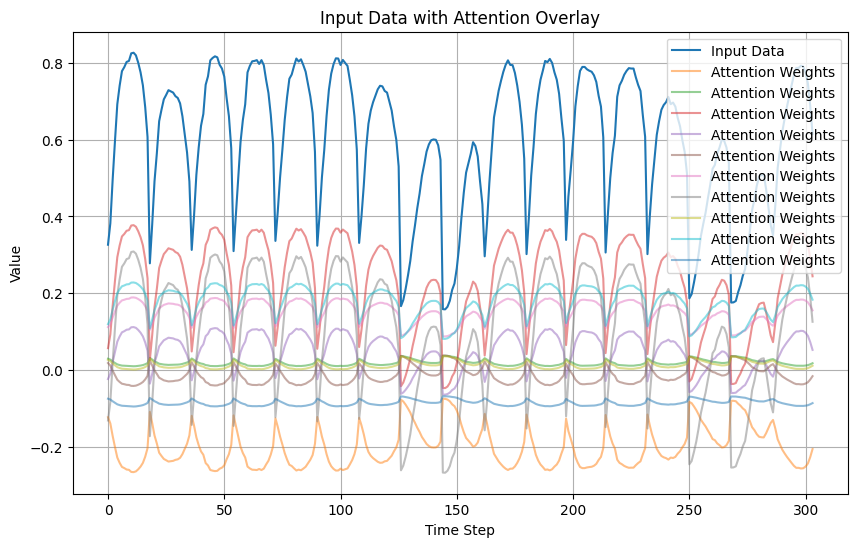

In [ ]:
# Plot the input data
plt.figure(figsize=(10, 6))
plt.plot(range(len(X_test)), X_test.squeeze(), label='Input Data')

# Overlay attention weights as a transparent overlay
plt.plot(range(len(X_test)), attention_weights.squeeze(), label='Attention Weights', alpha=0.5)

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Input Data with Attention Overlay')
plt.legend()
plt.grid(True)
plt.show()

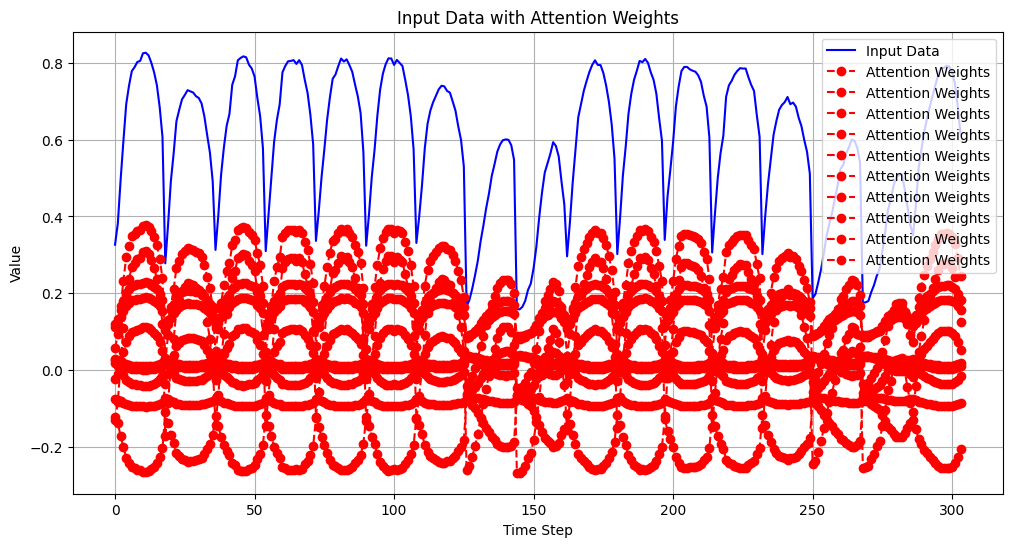

In [ ]:
# Plot input data and attention weights
plt.figure(figsize=(12, 6))
plt.plot(X_test.squeeze(), label='Input Data', color='blue')
plt.plot(attention_weights.squeeze(), label='Attention Weights', marker='o', linestyle='--', color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Input Data with Attention Weights')
plt.legend()
plt.grid(True)
plt.show()

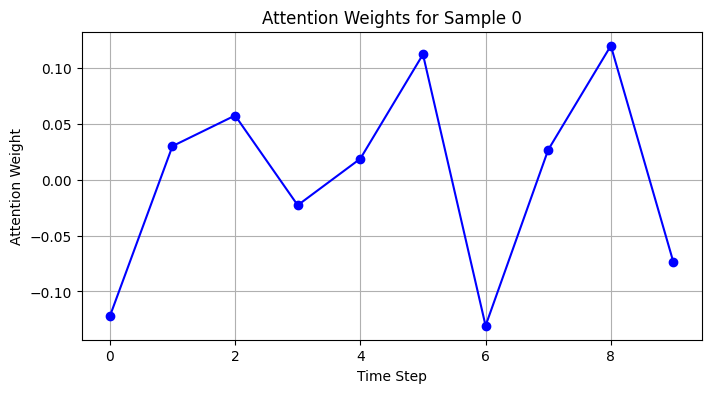

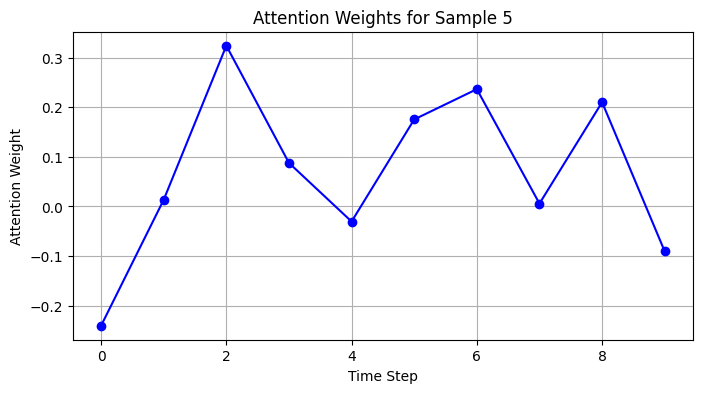

In [ ]:
# Select specific sample indices to visualize
sample_indices = [0, 5]  # Adjust as needed

# Plot attention weights for each selected sample
for idx in sample_indices:
    # Get attention weights for the sample
    attention_weights_sample = attention_weights[idx].squeeze()

    # Plot attention weights
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(attention_weights_sample)), attention_weights_sample, marker='o', linestyle='-', color='blue')
    plt.xlabel('Time Step')
    plt.ylabel('Attention Weight')
    plt.title(f'Attention Weights for Sample {idx}')
    plt.grid(True)
    plt.show()

# **CNN Model**

In [ ]:
# Reshape input data for CNN
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Define a CNN model for 1D input
def create_cnn_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train_cnn.shape[1], 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=[root_mean_squared_error])
    return model

In [ ]:
# Train the CNN model
cnn_model = create_cnn_model()
cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/50
26/26 [==============================] - 1s 12ms/step - loss: 0.1964 - root_mean_squared_error: 0.4306 - val_loss: 0.1106 - val_root_mean_squared_error: 0.3365
Epoch 2/50
26/26 [==============================] - 0s 3ms/step - loss: 0.0294 - root_mean_squared_error: 0.1552 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0829
Epoch 3/50
26/26 [==============================] - 0s 3ms/step - loss: 0.0062 - root_mean_squared_error: 0.0774 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0742
Epoch 4/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0049 - root_mean_squared_error: 0.0697 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0737
Epoch 5/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0042 - root_mean_squared_error: 0.0644 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0667
Epoch 6/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0035 - root_mean_squared_error: 0.0585 - val_loss: 0.0034 - val_root_mean_s

# **Evaluating both Models on test set**

In [ ]:
# Evaluate the best-performing RNN model on test set
rnn_loss, rnn_rmse = best_rnn_model.evaluate(X_test_reshaped, y_test)

# Evaluate the CNN model on test set
cnn_loss, cnn_rmse = cnn_model.evaluate(X_test_cnn, y_test)

print("RNN Model Performance (RMSE):", rnn_rmse)
print("CNN Model Performance (RMSE):", cnn_rmse)

10/10 [==============================] - 0s 3ms/step - loss: 1.2286e-07 - root_mean_squared_error: 3.0825e-04
RNN Model Performance (RMSE): 0.001303380005992949
CNN Model Performance (RMSE): 0.00030825447174720466


## **More graphs!**

In [ ]:
# Train the best-performing RNN model
rnn_history = best_rnn_model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Train the CNN model
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/50
26/26 [==============================] - 0s 7ms/step - loss: 4.0810e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.3028e-06 - val_root_mean_squared_error: 0.0016
Epoch 2/50
26/26 [==============================] - 0s 5ms/step - loss: 3.9806e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.1472e-06 - val_root_mean_squared_error: 0.0015
Epoch 3/50
26/26 [==============================] - 0s 5ms/step - loss: 3.9185e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.0783e-06 - val_root_mean_squared_error: 0.0015
Epoch 4/50
26/26 [==============================] - 0s 5ms/step - loss: 3.8920e-06 - root_mean_squared_error: 0.0020 - val_loss: 3.0772e-06 - val_root_mean_squared_error: 0.0015
Epoch 5/50
26/26 [==============================] - 0s 4ms/step - loss: 3.8604e-06 - root_mean_squared_error: 0.0019 - val_loss: 3.0419e-06 - val_root_mean_squared_error: 0.0015
Epoch 6/50
26/26 [==============================] - 0s 5ms/step - loss: 3.8359e-06 - root_mean_squared_error: 

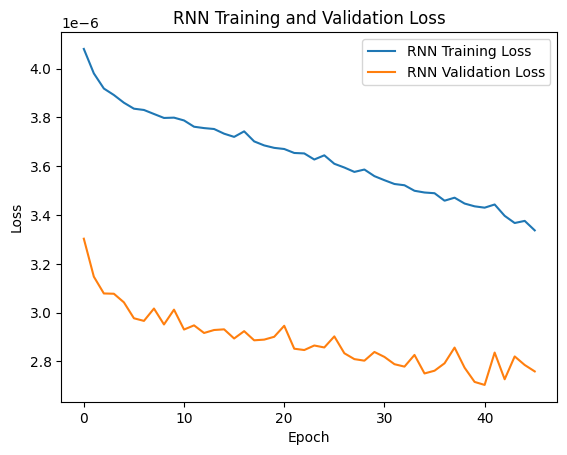

In [ ]:
# Plot training and validation loss for RNN
plt.plot(rnn_history.history['loss'], label='RNN Training Loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training and Validation Loss')
plt.legend()
plt.show()

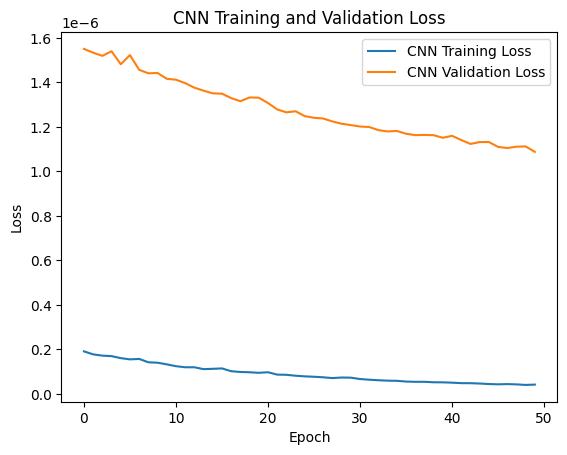

In [ ]:
# Plot training and validation loss for CNN
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Get predictions for RNN and CNN models
rnn_predictions = best_rnn_model.predict(X_test_reshaped)
cnn_predictions = cnn_model.predict(X_test_cnn)

10/10 [==============================] - 0s 2ms/step


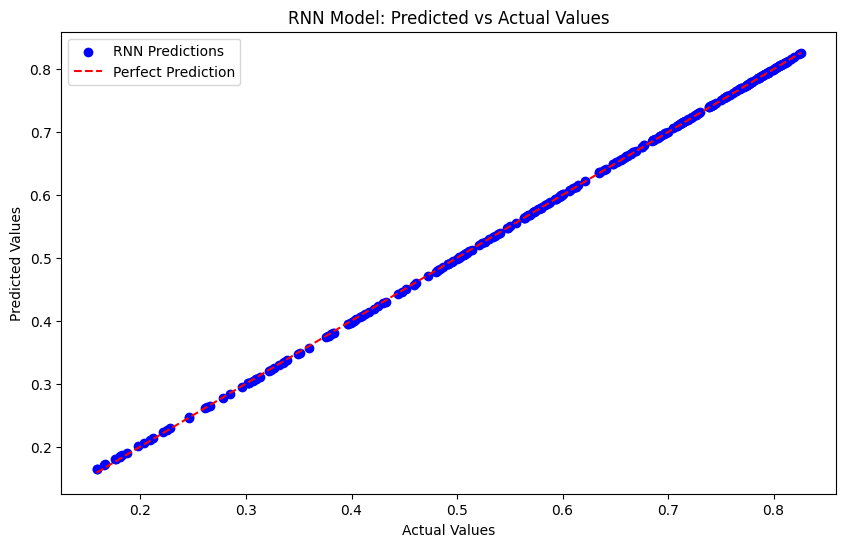

In [ ]:
# Plot predicted values versus actual values for RNN
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rnn_predictions, color='blue', label='RNN Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('RNN Model: Predicted vs Actual Values')
plt.legend()
plt.show()

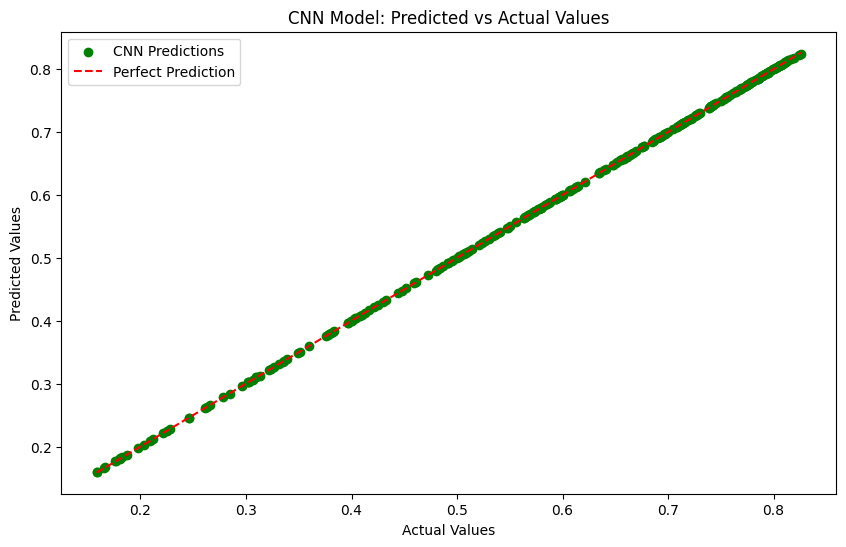

In [ ]:
# Plot predicted values versus actual values for CNN
plt.figure(figsize=(10, 6))
plt.scatter(y_test, cnn_predictions, color='green', label='CNN Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('CNN Model: Predicted vs Actual Values')
plt.legend()
plt.show()